# Experiment description
## Hypothesis: 
The amount of predictability of agressive behavior occurrence is bigger for some 'localidades'. 
## Method: 
Use of predictability and complementary measures such as constancy and contingency.

## Built-in methods

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import scipy
import math
from math import pi
%matplotlib inline

In [2]:
# https://plot.ly/python/v3/fft-filters/
def low_pass_filter(signal_values, fc =0.04, b =0.08):
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1
    n = np.arange(N)

    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1))
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)

    s = signal_values
    s = s - np.nanmean(s)
    filtered_signal = np.convolve(s, sinc_func)
    return filtered_signal

In [59]:
# Methods for slicing windows
def im2patches(im,n):
    patches = [];
    for i in range(len(im)-n):
        patch = im[i:(i+n-1)]        
        patch = patch - np.nanmean(patch);
        if(np.linalg.norm(patch)>0):
            patch = patch/np.linalg.norm(patch);
        if i==0:
            patches = patch;
        else:
            patches = np.vstack((patches,patch))
    return patches;


def writeEmbeding(timeSeries,lenWindow,samplePath, scenarioName):
    slicingWindows = im2patches(timeSeries,lenWindow);
    workingPath = '/Users/anamaria/Desktop/dev/security_project/periodicity_experiments/predictibility/slicing/'
    prevStation = str(samplePath);
    with open(workingPath+'slicingWindows'+"_"+str(prevStation)+"_"+str(scenarioName)+"_"+str(lenWindow)+'_.pickle', 'wb') as f:
        lv = slicingWindows.tolist();                        
        pickle.dump(lv, f, protocol=2)

    workingPath = '/Users/anamaria/Desktop/dev/security_project/periodicity_experiments/predictibility/timeSeries/'    
    with open(workingPath+'timeSeries'+"_"+str(prevStation)+"_"+str(scenarioName)+"_"+str(lenWindow)+'_.pickle', 'wb') as f:
        lv = timeSeries.tolist();                        
        pickle.dump(lv, f, protocol=2)



In [60]:
#Methods for predictibility
def getBarcode(samplePath,lenWindow,scenarioName):
    barcode = [];

    with open(workingPath+'timeSeries/'+'timeSeries_'+samplePath+"_"+str(scenarioName)+'_'+str(lenWindow)+'_'+'.pickle', 'rb') as f:
            timeSeries = pickle.load(f);            
    return (barcode,timeSeries);

def computeBarcodeEntropy(barsLenB0):
    barlen = np.array(barsLenB0);
    barlen = barlen/barlen.sum();
    hbc = 0;
    for i in range(barlen.shape[0]):
        if barlen[i]!=0:
            hbc = hbc-(barlen[i])*np.log(barlen[i]);
    return hbc;


def computeGeneralPredictability(timeSeries,binsData,lenWindow):
    # Colwell, R. K. (1974). Predictability, constancy, and contingency of periodic phenomena. Ecology, 55(5), 1148-1153.
    # Normalize the caudal values
    nLevels = binsData.shape[0]-1;
    matStations = np.array(timeSeries).reshape((np.array(timeSeries).shape[0]//lenWindow,lenWindow))    

    grandMean = np.mean(np.mean(matStations));
    #matStations = matStations / grandMean;
    N = np.zeros((nLevels,lenWindow));
    for i in range(1,matStations.shape[1]): 
        # Computes histograms per columns
        hist, bin_edges = np.histogram(matStations[:,i],bins = binsData);
        N[:,i] = hist;
    X = np.sum(N, axis=0);
    Y = np.sum(N, axis=1);
    Z = np.sum(Y);
    hx = 0;
    hy = 0;
    hxy = 0;
    for j in range(X.shape[0]):
        if X[j]!=0:
            hx = hx-(X[j]/Z)*np.log(X[j]/Z);
            
    for i in range(Y.shape[0]):
        if Y[i]!=0:
            hy = hy-(Y[i]/Z)*np.log(Y[i]/Z);
            
    for i in range(Y.shape[0]):
        for j in range(X.shape[0]):
            if N[i,j]!=0:
                hxy = hxy-((N[i,j]/Z)*np.log(N[i,j]/Z));    
    
    # predictability
    p = 1 - (hxy - hx)/np.log(N.shape[0]);
    # constancy
    c = 1 - hy/np.log(N.shape[0]);
    # Returns constancy and contingency
    return (c,p-c,p);



## Load data

In [5]:
data_location = '/Users/anamaria/Desktop/dev/security_project/datasets/verify_enrich_nuse_29112019.csv'
df_input = pd.read_csv(data_location,delimiter=",")

In [12]:
df_input['date']=pd.to_datetime(df_input['FECHA'])
df_by_date = pd.DataFrame(df_input.groupby(['date','LOCALIDAD']).size(),columns=["total_eventos"])

In [28]:
df_by_date = df_by_date.reset_index().set_index('date')

In [141]:
df_by_date[df_by_date['LOCALIDAD'] != 'SIN LOCALIZACION'].describe()

,total_eventos
count,14454.000000
mean,55.882040
std,49.671249
min,1.000000
25%,23.000000
50%,39.000000
75%,74.000000
max,485.000000


In [142]:
Levels=[23,39,74]
#Levels=[1,55,485]

In [143]:
levelCategories = list(map(lambda x: str(x), Levels))
levelCategories

['23', '39', '74']

## Localidades dataset

In [144]:
localidadesList = list(df_by_date.LOCALIDAD.unique())
localidadesList.remove('SIN LOCALIZACION')

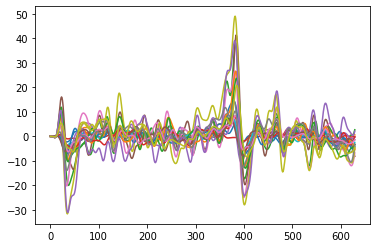

In [154]:
lenWindow = 7
for localidad in localidadesList:
    df_by_localidad = df_by_date[df_by_date['LOCALIDAD'] == localidad]
    df_localidad_values = pd.Series(df_by_localidad['total_eventos']).values
    #LPF
    filtered_df_days = low_pass_filter(df_localidad_values, fc =0.04, b =0.08)
    filtered_df_days = filtered_df_days[0:630]
    plt.plot(filtered_df_days)
    writeEmbeding(filtered_df_days,lenWindow,'aggressiveBehavior',localidad)

23
ANTONIO NARIÑO
---------------------------------
 
39
ANTONIO NARIÑO
---------------------------------
 
74
ANTONIO NARIÑO
---------------------------------
 
23
BARRIOS UNIDOS
---------------------------------
 
39
BARRIOS UNIDOS
---------------------------------
 
74
BARRIOS UNIDOS
---------------------------------
 
23
BOSA
---------------------------------
 
39
BOSA
---------------------------------
 
74
BOSA
---------------------------------
 
23
CANDELARIA
---------------------------------
 
39
CANDELARIA
---------------------------------
 
74
CANDELARIA
---------------------------------
 


/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


23
CHAPINERO
---------------------------------
 
39
CHAPINERO
---------------------------------
 
74
CHAPINERO
---------------------------------
 
23
CIUDAD BOLIVAR
---------------------------------
 
39
CIUDAD BOLIVAR
---------------------------------
 
74
CIUDAD BOLIVAR
---------------------------------
 
23
ENGATIVA
---------------------------------
 
39
ENGATIVA
---------------------------------
 
74
ENGATIVA
---------------------------------
 
23
FONTIBON
---------------------------------
 
39
FONTIBON
---------------------------------
 
74
FONTIBON
---------------------------------
 
23
KENNEDY
---------------------------------
 
39
KENNEDY
---------------------------------
 
74
KENNEDY
---------------------------------
 
23
LOS MARTIRES
---------------------------------
 
39
LOS MARTIRES
---------------------------------
 
74
LOS MARTIRES
---------------------------------
 
23
PUENTE ARANDA
---------------------------------
 
39
PUENTE ARANDA
---------------------------------
 


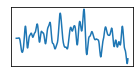

<Figure size 432x288 with 0 Axes>

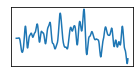

<Figure size 432x288 with 0 Axes>

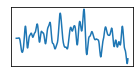

<Figure size 432x288 with 0 Axes>

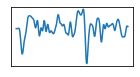

<Figure size 432x288 with 0 Axes>

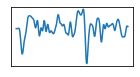

<Figure size 432x288 with 0 Axes>

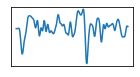

<Figure size 432x288 with 0 Axes>

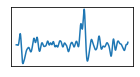

<Figure size 432x288 with 0 Axes>

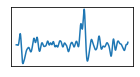

<Figure size 432x288 with 0 Axes>

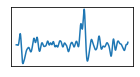

<Figure size 432x288 with 0 Axes>

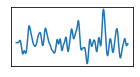

<Figure size 432x288 with 0 Axes>

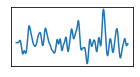

<Figure size 432x288 with 0 Axes>

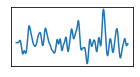

<Figure size 432x288 with 0 Axes>

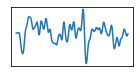

<Figure size 432x288 with 0 Axes>

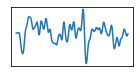

<Figure size 432x288 with 0 Axes>

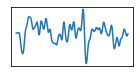

<Figure size 432x288 with 0 Axes>

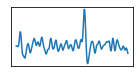

<Figure size 432x288 with 0 Axes>

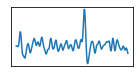

<Figure size 432x288 with 0 Axes>

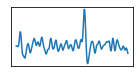

<Figure size 432x288 with 0 Axes>

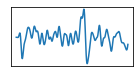

<Figure size 432x288 with 0 Axes>

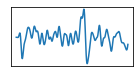

<Figure size 432x288 with 0 Axes>

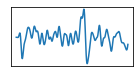

<Figure size 432x288 with 0 Axes>

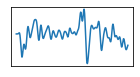

<Figure size 432x288 with 0 Axes>

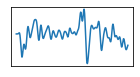

<Figure size 432x288 with 0 Axes>

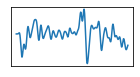

<Figure size 432x288 with 0 Axes>

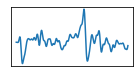

<Figure size 432x288 with 0 Axes>

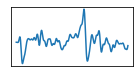

<Figure size 432x288 with 0 Axes>

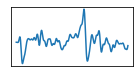

<Figure size 432x288 with 0 Axes>

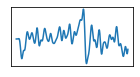

<Figure size 432x288 with 0 Axes>

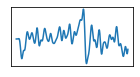

<Figure size 432x288 with 0 Axes>

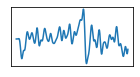

<Figure size 432x288 with 0 Axes>

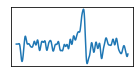

<Figure size 432x288 with 0 Axes>

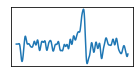

<Figure size 432x288 with 0 Axes>

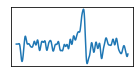

<Figure size 432x288 with 0 Axes>

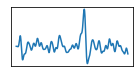

<Figure size 432x288 with 0 Axes>

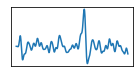

<Figure size 432x288 with 0 Axes>

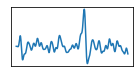

<Figure size 432x288 with 0 Axes>

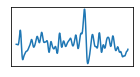

<Figure size 432x288 with 0 Axes>

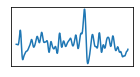

<Figure size 432x288 with 0 Axes>

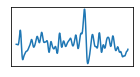

<Figure size 432x288 with 0 Axes>

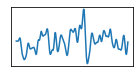

<Figure size 432x288 with 0 Axes>

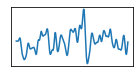

<Figure size 432x288 with 0 Axes>

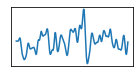

<Figure size 432x288 with 0 Axes>

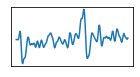

<Figure size 432x288 with 0 Axes>

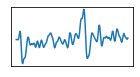

<Figure size 432x288 with 0 Axes>

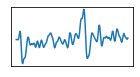

<Figure size 432x288 with 0 Axes>

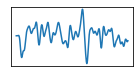

<Figure size 432x288 with 0 Axes>

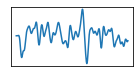

<Figure size 432x288 with 0 Axes>

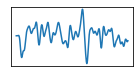

<Figure size 432x288 with 0 Axes>

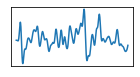

<Figure size 432x288 with 0 Axes>

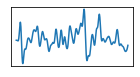

<Figure size 432x288 with 0 Axes>

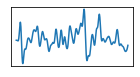

<Figure size 432x288 with 0 Axes>

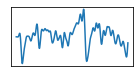

<Figure size 432x288 with 0 Axes>

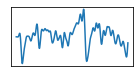

<Figure size 432x288 with 0 Axes>

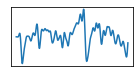

<Figure size 432x288 with 0 Axes>

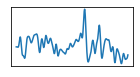

<Figure size 432x288 with 0 Axes>

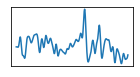

<Figure size 432x288 with 0 Axes>

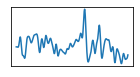

<Figure size 432x288 with 0 Axes>

In [157]:
#find predictibility, constancy and contingency
workingPath = '/Users/anamaria/Desktop/dev/security_project/periodicity_experiments/predictibility/';

flagF = True;
lenWindow = 7
for localidad in localidadesList:        
    for nLevels in Levels:
        for expName in ['aggressiveBehavior']:
        #for expName in ['aggressiveBehavior','random']:
            (barcode,timeSeries) = getBarcode(expName,lenWindow,localidad);
            binsLevels = np.linspace(np.min(timeSeries),np.max(timeSeries),nLevels);

            plt.figure(figsize=(2.2,1.1))
            plt.plot(timeSeries)
            plt.xticks([])
            plt.yticks([])
            plt.figure()


            print(nLevels)
            print(localidad)
            c,m,p = computeGeneralPredictability(timeSeries,binsLevels,lenWindow)
            #c,m,p = computeGeneralPredictability(timeSeries,binsLevels,len(timeSeries))

            if flagF==True:
                flagF = False
                predValues = np.array([expName,localidad,lenWindow,nLevels,p,m,c]);
            else:
                predValues = np.vstack((predValues, [expName,localidad,lenWindow,nLevels,p,m,c]))

        print('---------------------------------')
        print(' ')
    

In [158]:
predValues

array([['aggressiveBehavior', 'ANTONIO NARIÑO', '7', '23',
        '0.14518592532766816', '0.025919812899955152',
        '0.11926611242771301'],
       ['aggressiveBehavior', 'ANTONIO NARIÑO', '7', '39',
        '0.14271711759544436', '0.037339185291430876',
        '0.10537793230401349'],
       ['aggressiveBehavior', 'ANTONIO NARIÑO', '7', '74',
        '0.16418357688756446', '0.06734942933546706',
        '0.0968341475520974'],
       ['aggressiveBehavior', 'BARRIOS UNIDOS', '7', '23',
        '0.1758116154960372', '0.016756260957432323',
        '0.15905535453860487'],
       ['aggressiveBehavior', 'BARRIOS UNIDOS', '7', '39',
        '0.1712899146534621', '0.029186134716368328',
        '0.14210377993709378'],
       ['aggressiveBehavior', 'BARRIOS UNIDOS', '7', '74',
        '0.18395782676921402', '0.054339799199276784',
        '0.12961802756993723'],
       ['aggressiveBehavior', 'BOSA', '7', '23', '0.2927995374139505',
        '0.01864485107189573', '0.27415468634205475'],
  

In [159]:
df_prediction = pd.DataFrame(predValues, columns=['crime_type', 'localidad','lenWindow','crime_level','predictibility','contingency','constancy'])

In [160]:
df_agressiveBehavior = df_prediction[df_prediction['crime_type']=='aggressiveBehavior']

In [161]:
join=df_agressiveBehavior.pivot('localidad','crime_level','predictibility')

In [162]:
var1_order = []
var2_order = levelCategories
if len(var2_order) > 0:
    join = join.reindex(var2_order, axis=1)
if len(var1_order) > 0:
    join = join.reindex(var1_order)

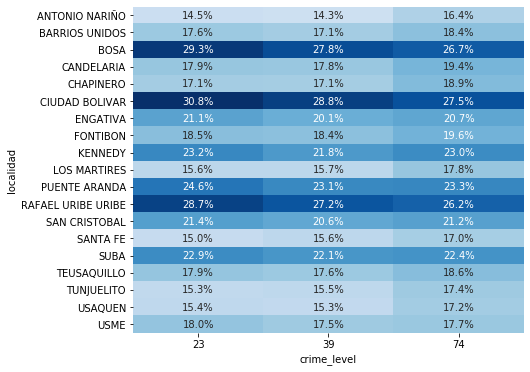

In [164]:
fig, ax = plt.subplots(1,1,sharex=True, sharey=True)
fig.set_size_inches(7, 6)
g=sns.heatmap(join.astype('float'),vmin=0.1, vmax=0.3,annot=True,fmt=".1%",linewidths=0,cmap="Blues",cbar=False)
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()